# Data Exploration

In [10]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from datetime import date
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
from matplotlib.dates import  DateFormatter
import seaborn as sns
from config import DATA_PATH,MAIN_FILE
import PandasHelper as pdh
from geopy.distance import vincenty
from mpl_toolkits.basemap import Basemap

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

## <pre>
<center>

| Dataset total records |  167,944,229 |
| :- | :-:
|   Number of devices  | 21,010,205|
|   Number of sites  | 53|
|   Number of devices on more than 2 sites (multi-sites devices) | 1,994,526|
|   Records for multi-sites devices  | 47,965,794|
|   Date range of records  | 2014-12-31 to 2015-12-31|

</center>
</pre>

![title](summary.jpg)

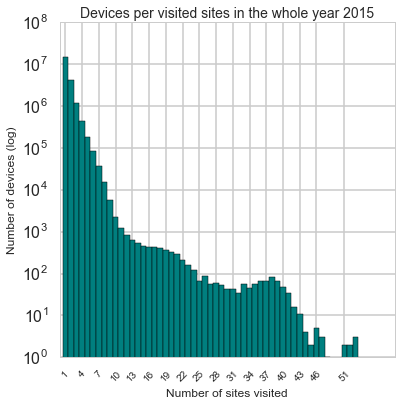

In [11]:
pdh.display_spread()

In [12]:
df = pd.read_csv(DATA_PATH+"groupby_device_date_site_final.csv",index_col=0)

In [13]:
df.columns=[['date',"count_sites"]]
df = df[df.count_sites>2]
df.head()

,date,count_sites
device_id,,
2224071,2015-09-06,3
2224101,2015-04-30,3
2224105,2015-05-13,3
2224107,2015-07-10,3
2224119,2015-07-22,3


In [14]:
groupy = (df.reset_index()).groupby('device_id').max()
groupy = groupy.sort_values(by='count_sites',ascending=False)
groupy = groupy.reset_index()

In [15]:
devices_idx = pd.read_csv(DATA_PATH+"indexes/devices_ix_multiple_sites.csv",index_col=0)

In [16]:
devices_idx.head()

,device_id,device_mac
0,24,76337b2689839e68b22235bdbb00ae5f
1,38,fc37652cf48ea844f371839e6274de22
2,40,d662ffcf6c668b6f325ab7980e720f6d
3,43,b4d3150a5951000b1701327d70bba5a9
4,50,861edd1e288e4f38e8a80807a32c3d24


In [17]:
groupy = pd.merge(groupy,devices_idx, on='device_id')
groupy.head()


,device_id,date,count_sites,device_mac
0,56118,2015-12-31,40,1d378b6df55bcc9dea58b6728e7e8285
1,3698,2015-12-31,39,71085a86d20b64c43ec3b9781ef70cfc
2,15796,2015-12-31,17,fd5ab440ac21cc7726883d844b119861
3,104104,2015-12-31,16,873dc43cc36d8b66dd295625ec9c2b56
4,38844,2015-12-31,16,96b40b45252bdcf12ffc90a1c5995f96


In [18]:
groupy.to_csv(DATA_PATH+"indexes/devices_date_3Sites_plus.csv",index=False)

In [19]:
data = pd.read_csv(DATA_PATH+"nielsen.csv",nrows=1000000,parse_dates=['first_timeframe'])

data['date']=data.first_timeframe.dt.date
data.date = pd.to_datetime(data.date)

In [20]:
groupy.date  = pd.to_datetime(groupy.date)


In [21]:
groupy.columns=['id','date','count_sites','device_id']
groupy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84925 entries, 0 to 84924
Data columns (total 4 columns):
id             84925 non-null int64
date           84925 non-null datetime64[ns]
count_sites    84925 non-null int64
device_id      84925 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [22]:
#result_data = pd.merge(data,groupy,on=['date'])

In [23]:
# result_data.head()

In [24]:
def display_repartition_per_visits():
    df = pd.read_csv(DATA_PATH+"groupby_device_date_site_final.csv",index_col=0)
    df.columns=[['date',"count_sites"]]
    df=df.sort_values('count_sites',ascending=False)
    visited_sites_per_day = df.groupby('count_sites').count()
    visited_sites_per_day= visited_sites_per_day.reset_index()
    bins = [0,1,2,100]
    group_names = ["One Site","2 Sites","3 Sites and more"]
    visited_sites_per_day['visited per day'] = pd.cut(visited_sites_per_day['count_sites'], bins, labels=group_names)
    visited_sites_per_day = visited_sites_per_day[['date','visited per day']]
    visited_sites_per_day = visited_sites_per_day.groupby('visited per day').sum()
    visited_sites_per_day.columns=['number_of_devices']
    visited_sites_per_day['%']=(visited_sites_per_day.number_of_devices/visited_sites_per_day.number_of_devices.sum(axis=0)*100).round(3)
    visited_sites_per_day.plot.pie(y='%',figsize=(6, 6), title='Number of visited sites per device per day - all year',legend=False,cmap=cm.GnBu)
    visited_sites_per_day.number_of_devices= visited_sites_per_day.number_of_devices.apply(lambda x : '{:,}'.format(x))
    
    lst = [df]
    del lst
    return visited_sites_per_day

,number_of_devices,%
visited per day,,
One Site,"29,676,294",90.962
2 Sites,"2,805,723",8.600
3 Sites and more,"142,916",0.438


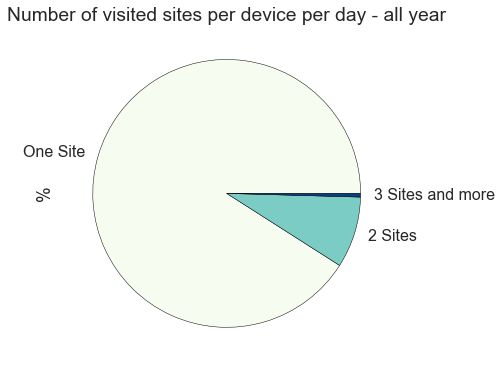

In [25]:
repartition = display_repartition_per_visits()
repartition.head()

In [26]:
def get_visits_timeline_all_devices():
    df = pd.read_csv(DATA_PATH+"groupby_device_date_site_final.csv",index_col=0)
    df.columns=[['date','count_sites']]
    df = df[df.count_sites>1]
    df = df.reset_index()
    df['date']= pd.to_datetime(df.date)
    df['weekday']= df['date'].dt.dayofweek
    df['day_from_start']= (df.date-date(2014,12,31)) / np.timedelta64(1, 'D')
    return df

In [27]:
def draw_devices_visits_timeline():
    df = get_visits_timeline_all_devices()
    df = df[df.count_sites>1]
    plt.scatter(df.day_from_start,df.count_sites, alpha=0.6,color='#007f7f')
    plt.title("Number of sites visited per device - 2015")
    plt.xlabel('days from 1/1/2015')

In [28]:
def create_summary_per_devices():
    df = get_visits_timeline_all_devices()
    ## define a table per device - total days tracked - average sites per day
    f = {'date':['count'], 'count_sites':['sum','mean']}
    df_device_visits = df.groupby('device_id').agg(f)
    # df_device_visits.columns = df_device_visits.columns.droplevel()
    df_device_visits =df_device_visits.sort([('count_sites','sum')],ascending=False)
    return df_device_visits

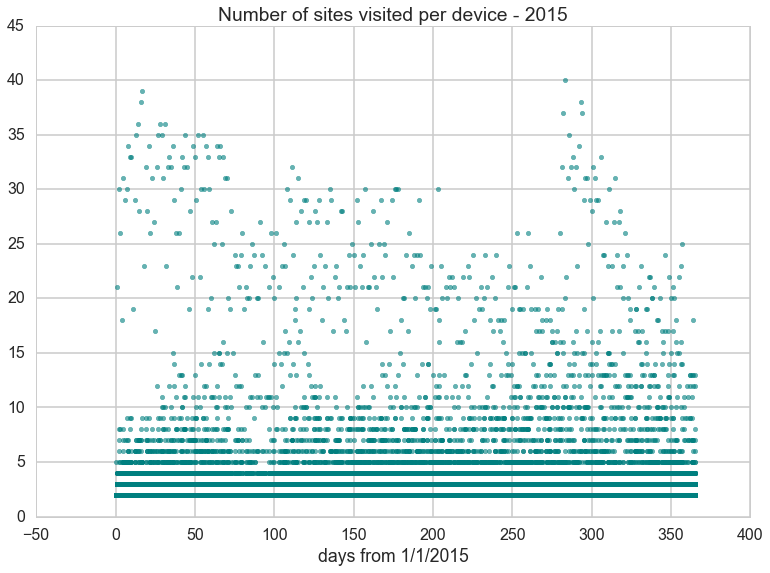

In [29]:
draw_devices_visits_timeline()

In [30]:
create_summary_per_devices().head()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


date count_sites           
          count         sum       mean
device_id                             
3698        366        7637  20.866120
56118       357        4278  11.983193
15796       366        2773   7.576503
38844       361        2515   6.966759
104104      344        2252   6.546512

In [31]:
def get_data(device_id_list):
    mac_list = pdh.search_device_mac(device_id_list)
    pdh.search_device_data(mac_list)
    return pd.read_csv(DATA_PATH+"data_search_results.csv")

In [32]:
lista = pdh.search_device_mac([610239,3698,56118,56784,2150983])


        Unnamed: 0  device_id                        device_mac
331            331       3698  71085a86d20b64c43ec3b9781ef70cfc
4573          4573      56118  1d378b6df55bcc9dea58b6728e7e8285
4622          4622      56784  84128eab87fca0c7ec8e902965dcd995
145284      145284     610239  c8d43c3c9c9285c5023ee6fe4999abee
477172      477172    2150983  324eddee35a2f1af32df6f6026d5bfdf


In [43]:
def draw_time_line_per_location(mac_address):
    data = pd.read_csv(DATA_PATH+"data_search_results.csv",index_col=0, parse_dates=['first_timeframe'])
    data.info()
    data_per_mac= data[data.device_id==mac_address]
    data_per_mac = data_per_mac.sort_values('first_timeframe',ascending=True)
    data_per_mac['city']=data_per_mac.site_name.apply(lambda x : x.split('(')[0])
    #data_per_mac = data_per_mac[data_per_mac.city.str.contains("Berlin")]
    data_per_mac_on_week = data_per_mac[(data_per_mac.first_timeframe.dt.dayofyear==24) & (data_per_mac.first_timeframe.dt.hour>10)
                                        & (data_per_mac.first_timeframe.dt.hour<23)]
    cmap = cm.get_cmap('Accent', 30)
    j=0
    for i, group in data_per_mac_on_week.groupby(["city"]):

        rgb = cmap(j)[:3]

        plt.plot_date(group.first_timeframe,group.dwell_time_s,
                     color=col.rgb2hex(rgb))
        j=j+1
    legendo = [i.decode('UTF-8') if isinstance(i, basestring) else i for i in data_per_mac_on_week.groupby(["city"]).groups]
    ax = plt.gca()
    ax.xaxis.set_major_formatter( DateFormatter('%Y-%m-%d %H-%M') )
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.title(mac_address + " - dwell time per site (seconds)")

    plt.legend(legendo,ncol=4, bbox_to_anchor=(1, 1.3),prop={'size':10} )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32112 entries, 9716 to 921767
Data columns (total 5 columns):
site_name          32112 non-null object
first_timeframe    32112 non-null datetime64[ns]
dwell_time_s       32112 non-null int64
device_id          32112 non-null object
visitor            32112 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB


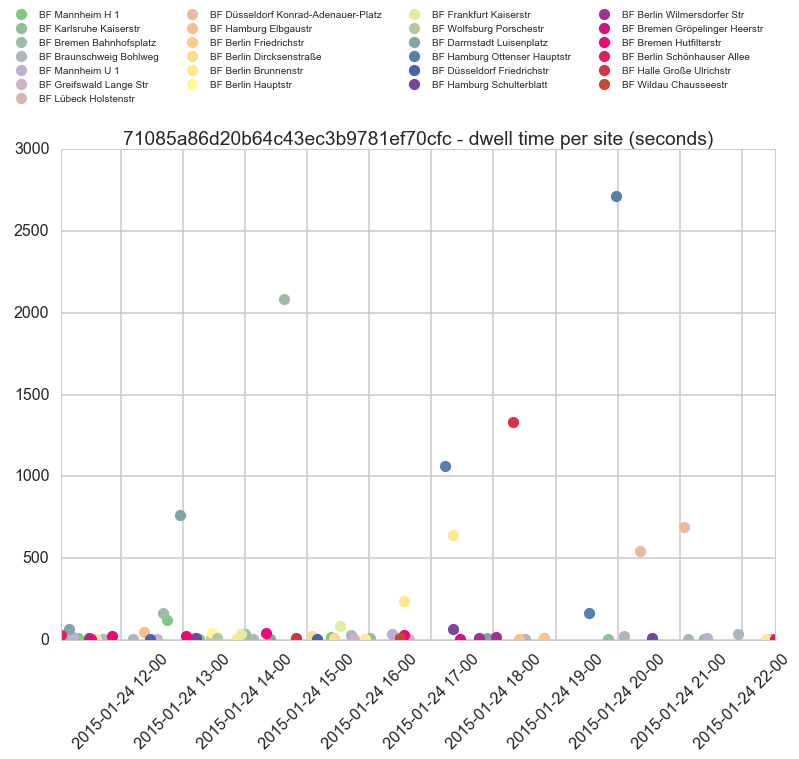

In [44]:
draw_time_line_per_location('71085a86d20b64c43ec3b9781ef70cfc')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32112 entries, 9716 to 921767
Data columns (total 5 columns):
site_name          32112 non-null object
first_timeframe    32112 non-null datetime64[ns]
dwell_time_s       32112 non-null int64
device_id          32112 non-null object
visitor            32112 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB


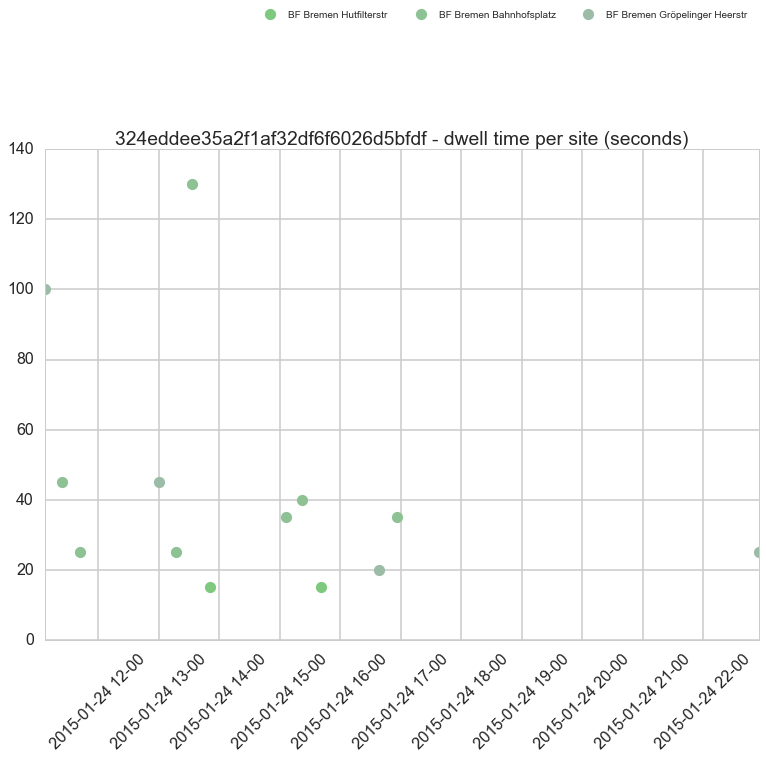

In [45]:
draw_time_line_per_location('324eddee35a2f1af32df6f6026d5bfdf')

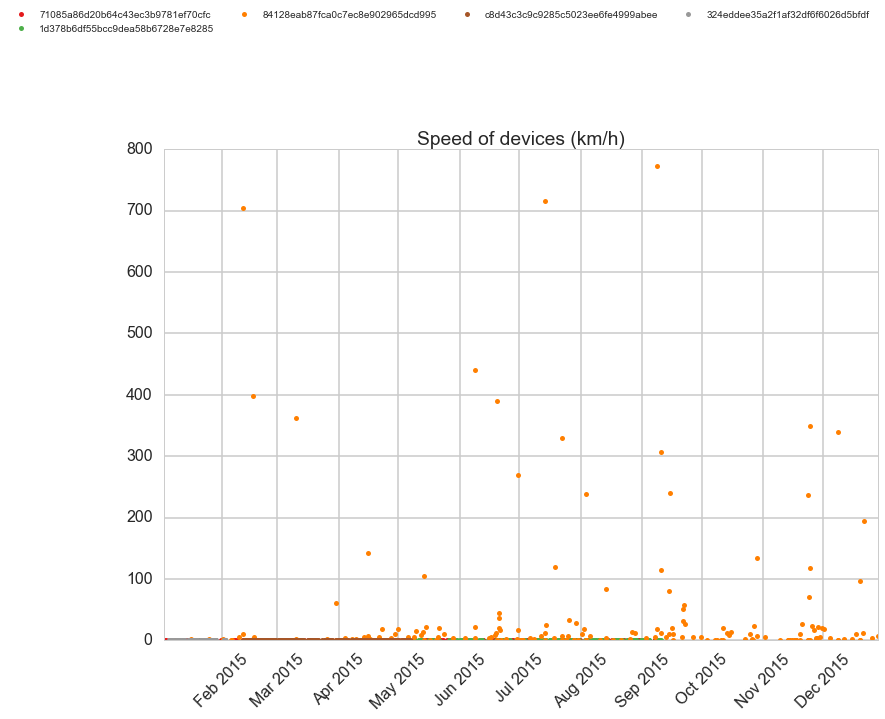

In [51]:
def compute_distance(x):
    
    if pd.notnull(x.chrono):
       
        return vincenty((x.x_before,x.y_before),(x.x_coordinate, x.y_coordinate)).km
    else : return 0
    
def compute_speed(x):
    if pd.notnull(x.chrono):
        time = x.chrono / np.timedelta64(1, 'm')
        
        return x.distance_traveled/time*60
    else: return 0
    

def draw_map(lats,lons):
   
    m = Basemap(llcrnrlon=4,llcrnrlat=47,urcrnrlon=20,urcrnrlat=56.0, 
                resolution='l',projection='cass',lon_0=13.5086876,lat_0= 52.5485208) 
    x, y = m(lons, lats) 
    m.plot(x, y, 'D-', markersize=10, linewidth=1, color='#ff2a6a', markerfacecolor='b') 
    
    m.etopo()
    plt.show() 
    
def compute_trip_speed(mac_address,j,legendo):
    data = pd.read_csv(DATA_PATH+"data_search_results.csv",index_col=0, parse_dates=['first_timeframe'])
    data = data[data.device_id==mac_address]
    sites_ix = pd.read_csv(DATA_PATH+"indexes/sites_ix.csv")
    speed_table = pd.merge(data,sites_ix,on='site_name')
    speed_table = speed_table[:200]
    speed_table = speed_table.sort_values(by='first_timeframe',ascending=True)
    speed_table['time_before'] = speed_table.first_timeframe.shift(1)
    speed_table['chrono']= speed_table.first_timeframe-speed_table.time_before
    
    speed_table['x_before'] = speed_table.x_coordinate.shift(1)
    speed_table['y_before'] = speed_table.y_coordinate.shift(1)
    
    
    speed_table['distance_traveled'] = speed_table.apply(lambda x : compute_distance(x),axis=1)
    speed_table['speed_kmh'] = speed_table.apply(lambda x : compute_speed(x),axis=1)
    cmap = cm.get_cmap('Set1', 5)
    rgb = cmap(j)[:3]
    plt.plot_date(speed_table.first_timeframe,speed_table.speed_kmh,color=col.rgb2hex(rgb),  marker='o', markersize=5)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.title("Speed of devices (km/h)")
    plt.legend(legendo,ncol=4, bbox_to_anchor=(1, 1.3),prop={'size':10} )
    return speed_table
    
df =[]
for i,maco in enumerate(lista):
   
    df.append(compute_trip_speed(maco,i,lista))

## Trip whole year for  device_mac
- 71085a86d20b64c43ec3b9781ef70cfc
- 1d378b6df55bcc9dea58b6728e7e8285
- 84128eab87fca0c7ec8e902965dcd995
- c8d43c3c9c9285c5023ee6fe4999abee
- 324eddee35a2f1af32df6f6026d5bfdf

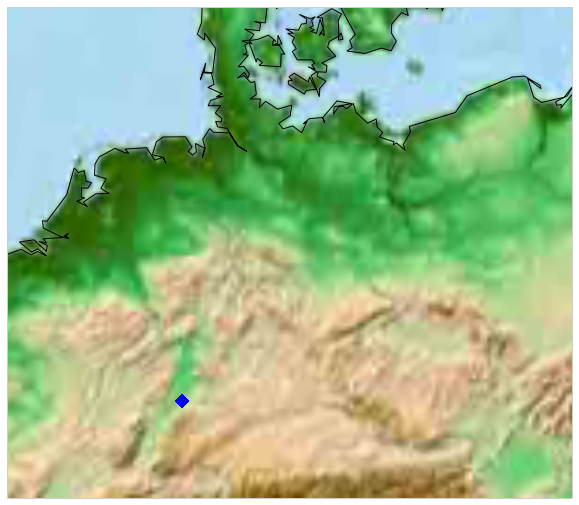

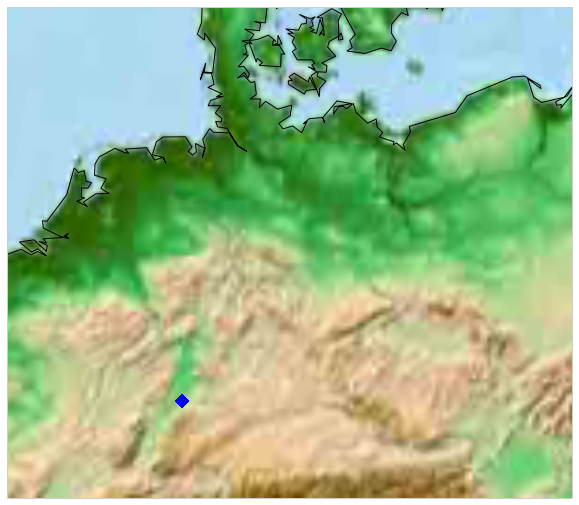

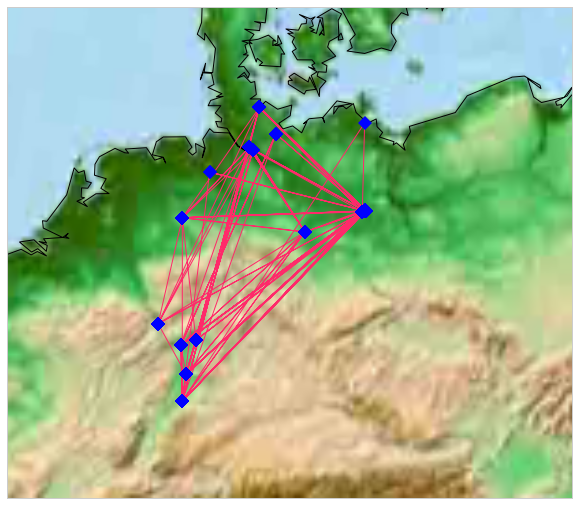

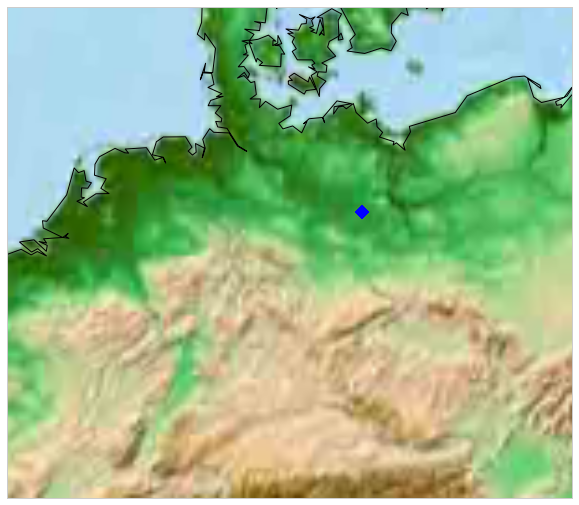

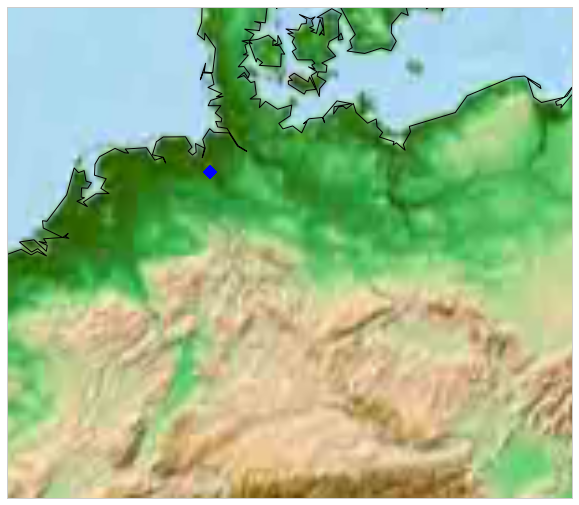

In [52]:
for df1 in df:
    draw_map(df1.x_coordinate.values.tolist(),df1.y_coordinate.values.tolist())

In [ ]:
# df = get_data([610239,3698,56118,56784,2150983])

In [55]:
def draw_visits():
    groupy = get_visits_timeline_all_devices()
   
    devices_per_day_weekday = groupy[groupy.weekday<6]
    devices_per_day_saturday = groupy[groupy.weekday==5]
    devices_per_day_sunday = groupy[groupy.weekday==6]
    devices_per_day_weekday = devices_per_day_weekday.groupby('date')['count_sites'].count()
    devices_per_day_saturday = devices_per_day_saturday.groupby('date')['count_sites'].count()
    devices_per_day_sunday = devices_per_day_sunday.groupby('date')['count_sites'].count()
    
    devices_per_day_weekday = devices_per_day_weekday.sort_index(ascending=True)
    devices_per_day_saturday = devices_per_day_saturday.sort_index(ascending=True)
    devices_per_day_sunday = devices_per_day_sunday.sort_index(ascending=True)
    
    devices_per_day_weekday.plot(alpha=1,c='#087fa1',title="Number of multi-sites devices recorded per day (green:saturday,red:sunday)")
    devices_per_day_saturday.plot(alpha=0.7,c='#66ff99')
    devices_per_day_sunday.plot(alpha=0.7,c='#4b122e')

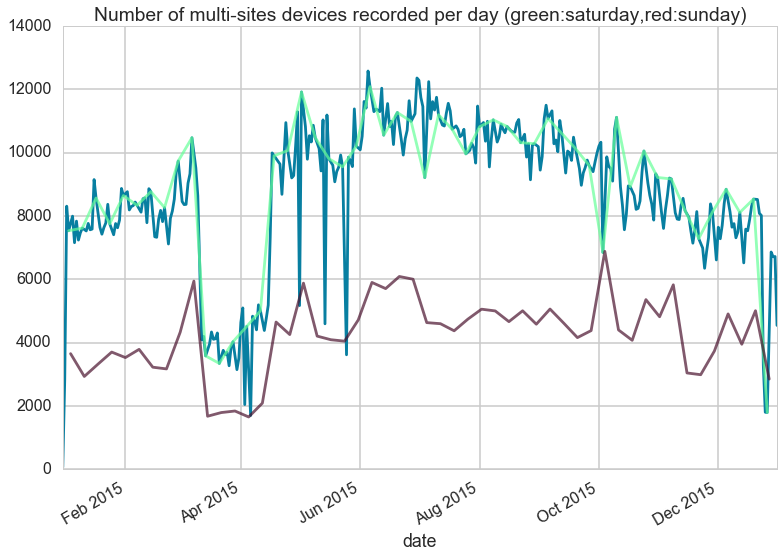

In [56]:
draw_visits()